<a href="https://colab.research.google.com/github/Tristan-Brown1096/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [31]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [42]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', index_col='id')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [43]:
train.date_recorded = pd.to_datetime(train.date_recorded)
test.date_recorded = pd.to_datetime(test.date_recorded)

In [44]:
import numpy as np
train.construction_year = train.construction_year.replace(0, np.nan)
test.construction_year = test.construction_year.replace(0, np.nan)

In [45]:
train['age_at_inspection'] = train['date_recorded'].dt.year - train['construction_year']
test['age_at_inspection'] = test['date_recorded'].dt.year - test['construction_year']

In [46]:
train['pop_served'] = train.age_at_inspection * train.population
test['pop_served'] = test.age_at_inspection * test.population

In [47]:
def wrangle(X):
  #copy X
  X = X.copy()

  #replace weird latitude values
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  #replace lat/long 0 values with NaN
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  #drop constant columns
  X = X.drop([col for col in X if X[col].nunique()==1], axis=1)

  #drop high cardinality columns
  hc = [col for col in X.describe(include='object').columns if X[col].nunique() > 100]
  X = X.drop(hc, axis=1)

  #drop repeated column
  X = X.drop(['quantity_group', 'date_recorded', 'construction_year', 'population', 'age_at_inspection'], axis=1)

  #return new version 
  return X

In [48]:
train = wrangle(train)
test = wrangle(test)

#Split data

In [49]:
y = train['status_group']

X = train.drop('status_group', axis=1)

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

#Build model_27

In [11]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
model_27 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_estimators=500, max_features='sqrt', max_depth=20)
)

model_27.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='sqrt',
                                   

In [12]:
print('Training accuracy', model_27.score(X_train, y_train))
print('Validation accuracy', model_27.score(X_val, y_val))

Training accuracy 0.9497053872053872
Validation accuracy 0.805050505050505


#Build model_28

In [13]:
model_28 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_estimators=400, max_features='auto', max_depth=19)
    
)

model_28.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=19, max_features='auto',
                                   

In [14]:
print('Training accuracy', model_28.score(X_train, y_train))
print('Validation accuracy', model_28.score(X_val, y_val))

Training accuracy 0.9367003367003367
Validation accuracy 0.8056397306397306


#Build model_29

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [16]:
scaler = StandardScaler()
oc = OrdinalEncoder()
imputer = SimpleImputer()
pca = PCA(.9)

In [17]:
X_train_pca = pca.fit_transform(scaler.fit_transform(imputer.fit_transform(oc.fit_transform(X_train))))
X_val_pca = pca.fit_transform(scaler.fit_transform(imputer.fit_transform(oc.fit_transform(X_val))))

In [18]:
model_29 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_estimators=400, max_features='auto', max_depth=19)
    
)

model_29.fit(X_train_pca, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(boo...ap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=19, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                         

In [19]:
print('Training accuracy', model_29.score(X_train_pca, y_train))
print('Validation accuracy', model_29.score(X_val_pca, y_val))

Training accuracy 0.9441919191919191
Validation accuracy 0.732912457912458


#Build model_30

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
params = {'randomforestclassifier__n_estimators': range(300, 600, 20),
          'randomforestclassifier__max_depth': range(14, 21),
          'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}

gs = RandomizedSearchCV(model_27, param_distributions=params, n_iter=10, n_jobs=-1, verbose=1, cv=5, scoring='accuracy')

In [ ]:
gs.fit(X_train, y_train)
gs.best_params_

KeyboardInterrupt: ignored

In [51]:
model_30 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_estimators=520, max_features='log2', max_depth=19)
)

model_30.fit(X_train, y_train)

print('Training accuracy', model_30.score(X_train, y_train))
print('Validation accuracy', model_30.score(X_val, y_val))

Training accuracy 0.9272937710437711
Validation accuracy 0.8058922558922559


In [21]:
from sklearn.metrics import plot_confusion_matrix, classification_report

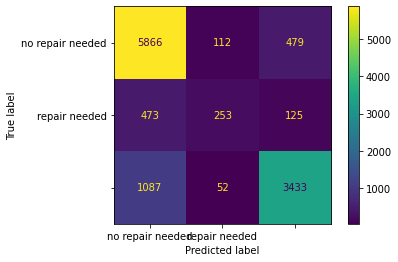

In [23]:
plot_confusion_matrix(model_30, X_val, y_val, 
                      values_format=".0f", 
                      display_labels=['no repair needed', 'repair needed'])

In [24]:
print(classification_report(y_val, model_30.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.79      0.91      0.85      6457
functional needs repair       0.61      0.30      0.40       851
         non functional       0.85      0.75      0.80      4572

               accuracy                           0.80     11880
              macro avg       0.75      0.65      0.68     11880
           weighted avg       0.80      0.80      0.79     11880



In [56]:
from google.colab import files

X_test = test
y_pred_11 = model_30.predict(X_test)
y_pred_11 = pd.DataFrame(y_pred_11, columns=['status_group'], index=X_test.index)
y_pred_11.to_csv('tristan_brown_submit_11.csv')
files.download('tristan_brown_submit_11.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# Filenames of your submissions you want to ensemble
submits = ['tristan_brown_submit_7.csv', 'tristan_brown_submit_8.csv', 
         'tristan_brown_submit_9.csv', 'tristan_brown_submit_10.csv',
         'tristan_brown_submit_11.csv']
 
target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in submits)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]
 
sample_submission = pd.read_csv('tristan_brown_submit_11.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('tristan_brown_submit_12.csv', index=False)
files.download('tristan_brown_submit_12.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Final model

In [59]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', index_col='id')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [60]:
def wrangle(X):
  #copy X
  X = X.copy()

  #replace weird latitude values
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  #replace lat/long 0 values with NaN
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  #drop constant columns
  X = X.drop([col for col in X if X[col].nunique()==1], axis=1)

  #drop high cardinality columns
  hc = [col for col in X.describe(include='object').columns if X[col].nunique() > 100]
  X = X.drop(hc, axis=1)

  #drop repeated column
  X = X.drop(['quantity_group'], axis=1)

  #return new version 
  return X

In [61]:
train = wrangle(train)
test = wrangle(test)

In [62]:
y_2 = train['status_group']

X_2 = train.drop('status_group', axis=1)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2, y_2, test_size=0.2, random_state = 42)

In [63]:
model_31 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_estimators=500, max_features='sqrt', max_depth=20)
)

model_31.fit(X_train_2, y_train_2)

print('Training accuracy', model_31.score(X_train_2, y_train_2))
print('Validation accuracy', model_31.score(X_val_2, y_val_2))

Training accuracy 0.9481060606060606
Validation accuracy 0.8090909090909091


In [65]:
X_test_2 = test
y_pred_13 = model_31.predict(X_test_2)
y_pred_13 = pd.DataFrame(y_pred_13, columns=['status_group'], index=X_test_2.index)
y_pred_13.to_csv('tristan_brown_submit_13.csv')
files.download('tristan_brown_submit_13.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Build model_32

In [66]:
model_32 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_estimators=520, max_features='log2', max_depth=19)
)

model_32.fit(X_train_2, y_train_2)

print('Training accuracy', model_32.score(X_train_2, y_train_2))
print('Validation accuracy', model_32.score(X_val_2, y_val_2))

Training accuracy 0.9322390572390572
Validation accuracy 0.8080808080808081


In [67]:
y_pred_14 = model_32.predict(X_test_2)
y_pred_14 = pd.DataFrame(y_pred_14, columns=['status_group'], index=X_test_2.index)
y_pred_14.to_csv('tristan_brown_submit_14.csv')
files.download('tristan_brown_submit_14.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>